In [ ]:
# ================================================================
# LATENT GENERATION FOR M3FD DATASET USING DDIM INVERSION (t=400)
# ================================================================

import os, glob, torch, io
from tqdm.auto import tqdm
from PIL import Image
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDIMScheduler

# -------------------------------
# Configuration
# -------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32

MODEL_ID = "CompVis/stable-diffusion-v1-4"
T_TARGET = 400
NUM_TRAIN_STEPS = 1000
RESIZE_TO = 256

# === Update these paths ===
RGB_DIR = "/media/nas_mount/research3/aman_kr/M3FD_Detection/Vis"
IR_DIR  = "/media/nas_mount/research3/aman_kr/M3FD_Detection/Ir"
OUT_TRAIN = "/media/nas_mount/research3/aman_kr/latents_t400_train"
OUT_TEST  = "/media/nas_mount/research3/aman_kr/latents_t400_test"

TRAIN_SPLIT = 0.80  # 80% train, 20% test

os.makedirs(OUT_TRAIN, exist_ok=True)
os.makedirs(OUT_TEST, exist_ok=True)

# -------------------------------
# Preprocessing
# -------------------------------
preprocess = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.Resize((RESIZE_TO, RESIZE_TO)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# -------------------------------
# Helper functions
# -------------------------------
@torch.no_grad()
def get_empty_prompt_embeds(pipe):
    """Get unconditional text embeddings for empty prompt."""
    tokens = pipe.tokenizer([""], padding="max_length",
                            max_length=pipe.tokenizer.model_max_length,
                            return_tensors="pt")
    embeds = pipe.text_encoder(tokens.input_ids.to(pipe.device))[0].to(dtype=DTYPE)
    return embeds

@torch.no_grad()
def vae_encode(pipe, image):
    """Encode image → latent (z0)."""
    x = preprocess(image).unsqueeze(0).to(pipe.device, dtype=DTYPE)
    z = pipe.vae.encode(x).latent_dist.sample() * pipe.vae.config.scaling_factor
    return z

@torch.no_grad()
def ddim_invert_to_t(z0, pipe, cond_embeds, t_target):
    """Deterministic DDIM forward (0 → t_target)."""
    scheduler = pipe.scheduler
    scheduler.set_timesteps(NUM_TRAIN_STEPS)
    alphas_cumprod = scheduler.alphas_cumprod.to(pipe.device)

    z = z0.clone()
    for t in range(t_target):
        z_in = scheduler.scale_model_input(z, t)
        eps = pipe.unet(z_in, t, encoder_hidden_states=cond_embeds).sample
        a_t, a_tp1 = alphas_cumprod[t], alphas_cumprod[t+1]
        x0_hat = (z - (1 - a_t).sqrt() * eps) / a_t.sqrt()
        z = a_tp1.sqrt() * x0_hat + (1 - a_tp1).sqrt() * eps
    return z

# -------------------------------
# Latent generation (train/test)
# -------------------------------
@torch.no_grad()
def generate_latents(rgb_dir, ir_dir, out_train, out_test, train_split=0.8):
    # ... Loading Stable Diffusion ({MODEL_ID}) ...#
    pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=DTYPE).to(DEVICE)
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler.set_timesteps(NUM_TRAIN_STEPS)
    cond = get_empty_prompt_embeds(pipe)


    # ..... bCollect aligned pairs....#
    rgb_files = sorted(glob.glob(os.path.join(rgb_dir, "*.*")))
    ir_files  = sorted(glob.glob(os.path.join(ir_dir,  "*.*")))
    ir_set = {os.path.basename(f) for f in ir_files}

    pairs = [f for f in rgb_files if os.path.basename(f) in ir_set]
    n_total = len(pairs)
    n_train = int(n_total * train_split)
    n_test  = n_total - n_train

    train_pairs = pairs[:n_train]
    test_pairs  = pairs[n_train:]

    print(f"Total pairs found: {n_total}")
    print(f"→ Train: {n_train} ({train_split*100:.1f}%)")
    print(f"→ Test:  {n_test} ({(1-train_split)*100:.1f}%)")

    # Process both splits
    for split_name, split_pairs, out_dir in [
        ("train", train_pairs, out_train),
        ("test",  test_pairs,  out_test)
    ]:
        print(f"\n Generating {split_name} latents (t={T_TARGET}) ...")
        for rgb_path in tqdm(split_pairs, desc=f"DDIM invert {split_name}"):
            fname = os.path.basename(rgb_path)
            ir_path = os.path.join(ir_dir, fname)
            out_pt = os.path.join(out_dir, fname.rsplit(".", 1)[0] + ".pt")

            if os.path.exists(out_pt):
                continue  # skip already done

            try:
                rgb_img = Image.open(rgb_path).convert("RGB")
                ir_img  = Image.open(ir_path).convert("L") 
                ir_img  = ir_img.convert("RGB") 
            except Exception as e:
                print(f"Error reading {fname}: {e}")
                continue

            # Encode to latent
            z0_rgb = vae_encode(pipe, rgb_img)
            z0_ir  = vae_encode(pipe, ir_img)

            # DDIM forward to t=400
            z400_rgb = ddim_invert_to_t(z0_rgb, pipe, cond, T_TARGET)
            z400_ir  = ddim_invert_to_t(z0_ir,  pipe, cond, T_TARGET)

            # Save latent pair
            torch.save({
                "rgb400": z400_rgb.half().cpu(),
                "ir400":  z400_ir.half().cpu(),
                "shape":  list(z400_rgb.shape),
                "t":      T_TARGET
            }, out_pt)

        print(f"Completed {split_name} latents → {len(split_pairs)} files saved to: {out_dir}")

# -------------------------------
# Run it
# -------------------------------
generate_latents(RGB_DIR, IR_DIR, OUT_TRAIN, OUT_TEST, train_split=TRAIN_SPLIT)


In [ ]:
# ================================================================
# Train + Evaluate U-Net on precomputed M3FD DDIM t=400 latents
# ================================================================

import os, glob, torch, contextlib
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# Config
# -------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32
USE_FP16 = (DEVICE == "cuda")

TRAIN_LATENT_DIR = "/media/nas_mount/research3/aman_kr/latents_t400_train"
TEST_LATENT_DIR  = "/media/nas_mount/research3/aman_kr/latents_t400_test"

BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 100
MODEL_SAVE_PATH = "unet_latent_m3fd_t400.pth"

# ================================================================
# Dataset
# ================================================================
class LatentM3FD400(torch.utils.data.Dataset):
    def __init__(self, latent_dir):
        self.files = sorted(glob.glob(os.path.join(latent_dir, "*.pt")))
        assert len(self.files) > 0, f"No latents found in {latent_dir}"
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        data = torch.load(self.files[idx], map_location="cpu")
        return data["rgb400"].squeeze(0), data["ir400"].squeeze(0)

# ================================================================
# U-Net
# ================================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups=min(32, out_ch), num_channels=out_ch),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups=min(32, out_ch), num_channels=out_ch),
            nn.SiLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Fix spatial mismatch (odd dims)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Concatenate
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=4, out_ch=4, bilinear=True):
        super().__init__()
        self.inc = DoubleConv(in_ch, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 512)  

        self.up1 = Up(512 + 512, 256, bilinear)
        self.up2 = Up(256 + 256, 128, bilinear)
        self.up3 = Up(128 + 128, 64, bilinear)
        self.up4 = Up(64 + 64, 64, bilinear)

        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)   # 64
        x2 = self.down1(x1) # 128
        x3 = self.down2(x2) # 256
        x4 = self.down3(x3) # 512
        x5 = self.down4(x4) # 512
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

# ================================================================
# Train and evaluate
# ================================================================
def train_and_eval():
    print(f"Using device: {DEVICE}")
    train_dataset = LatentM3FD400(TRAIN_LATENT_DIR)
    test_dataset  = LatentM3FD400(TEST_LATENT_DIR)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = UNet().to(DEVICE)
    opt = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)

    for epoch in range(1, EPOCHS + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
        for rgb, ir in pbar:
            rgb, ir = rgb.to(DEVICE), ir.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=DEVICE, dtype=torch.float16, enabled=USE_FP16):
                pred = model(rgb)
                loss = loss_fn(pred, ir)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            pbar.set_postfix(loss=loss.item())

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved at {MODEL_SAVE_PATH}")

    # --- Evaluation ---
    psnr = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
    model.eval()
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for rgb, ir in tqdm(test_loader, desc="Evaluating"):
            rgb, ir = rgb.to(DEVICE), ir.to(DEVICE)
            with torch.amp.autocast(device_type=DEVICE, dtype=torch.float16, enabled=USE_FP16):
                pred = model(rgb)
            psnr_vals.append(psnr(pred, ir).item())
            ssim_vals.append(ssim(pred, ir).item())
    print(f"\nAverage PSNR: {sum(psnr_vals)/len(psnr_vals):.4f}")
    print(f"Average SSIM: {sum(ssim_vals)/len(ssim_vals):.4f}")

train_and_eval()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

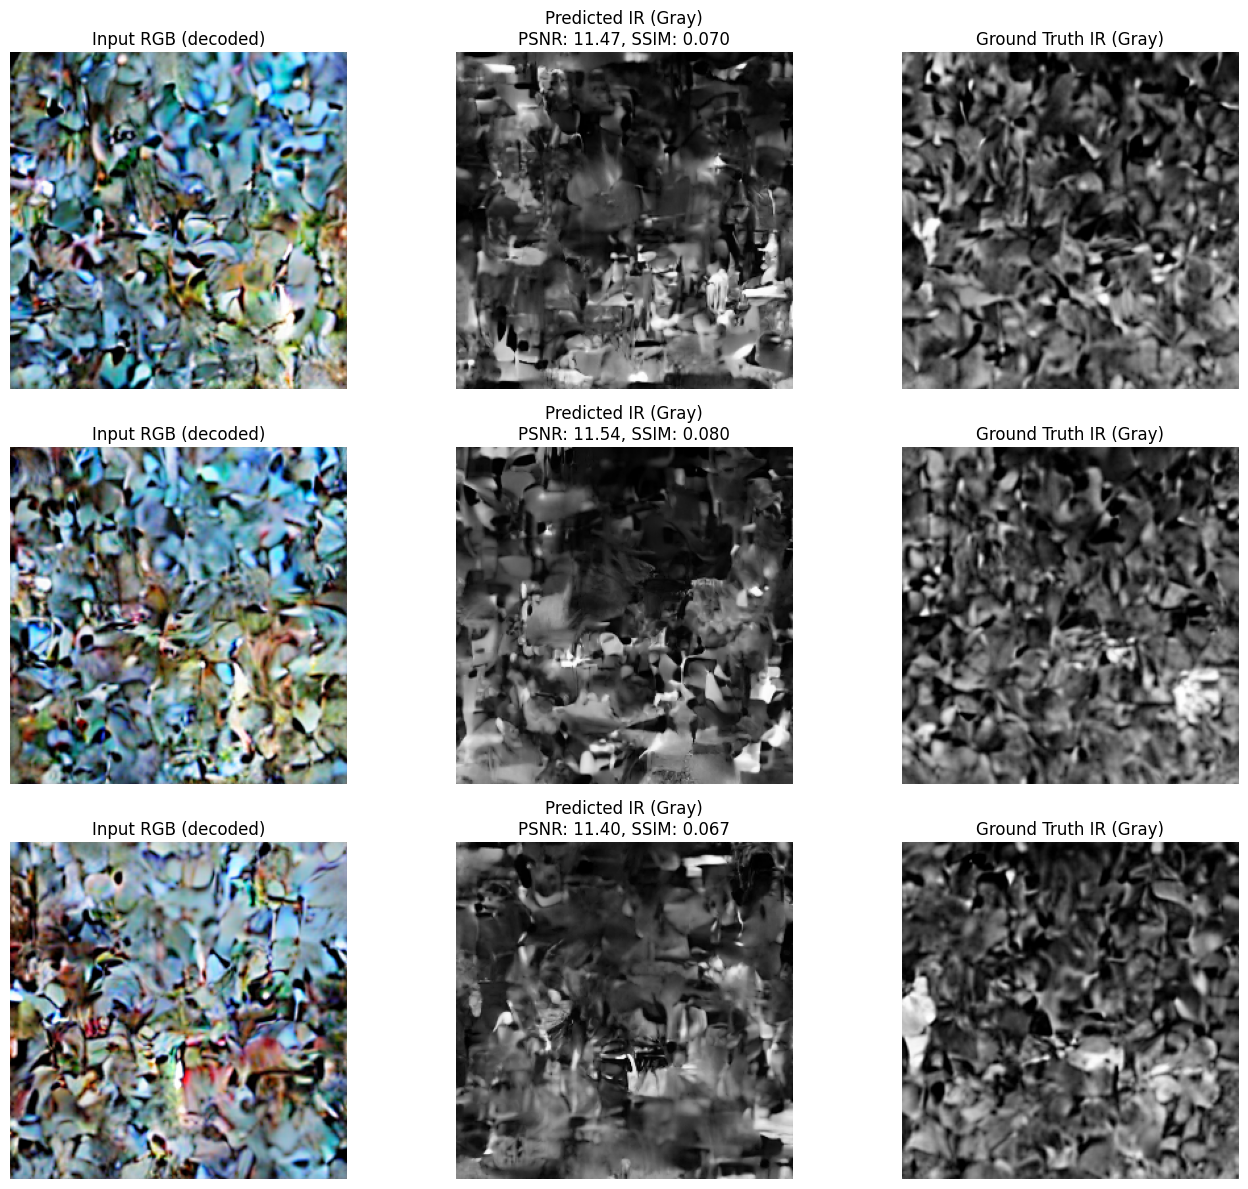


Average PSNR: 11.4730
 Average SSIM: 0.0725


In [ ]:
# ================================================================
# EVALUATION + VISUALIZATION ON TEST LATENTS (DDIM t=400)
# ================================================================
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDIMScheduler
import numpy as np

MODEL_SAVE_PATH = "unet_latent_m3fd_t400.pth"
@torch.no_grad()
def vae_decode_latent(z0, pipe):
    """
    Decode a latent z0 using the Stable Diffusion VAE and return a float32 numpy image in [0,1].
    """
    z0 = z0.to(device=DEVICE, dtype=DTYPE)
    x = pipe.vae.decode(z0 / pipe.vae.config.scaling_factor).sample  # [B,3,H,W]
    x = (x.clamp(-1, 1) + 1) / 2.0                                   # normalize to [0,1]
    x = x[0].permute(1, 2, 0).detach().cpu().numpy().astype("float32")  # safe for matplotlib
    return x

def evaluate_and_visualize(model_path, test_dir, n_samples=6):
    pipe = StableDiffusionPipeline.from_pretrained(
        "CompVis/stable-diffusion-v1-4", torch_dtype=DTYPE
    ).to(DEVICE)
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.vae.eval()

    # Load trained translator model
    model = UNet().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    # Metrics
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

    # Load test latents
    test_files = sorted(glob.glob(os.path.join(test_dir, "*.pt")))
    n_samples = min(n_samples, len(test_files))
    psnr_vals, ssim_vals = [], []

    fig, axes = plt.subplots(n_samples, 3, figsize=(14, 4 * n_samples))
    if n_samples == 1:
        axes = [axes]

    for ax_row, fpath in zip(axes, test_files[:n_samples]):
        data = torch.load(fpath, map_location="cpu")
        rgb_latent = data["rgb400"].to(DEVICE)
        ir_latent  = data["ir400"].to(DEVICE)

        # Predict IR latent
        with torch.amp.autocast(device_type=DEVICE, dtype=torch.float16, enabled=USE_FP16):
            ir_pred_latent = model(rgb_latent)

        # --- Decode latents ---
        rgb_dec = vae_decode_latent(rgb_latent, pipe)
        ir_true_dec = vae_decode_latent(ir_latent, pipe)
        ir_pred_dec = vae_decode_latent(ir_pred_latent, pipe)

        # --- Convert IR images to grayscale ---
        ir_true_gray = np.mean(ir_true_dec, axis=2, keepdims=True)
        ir_pred_gray = np.mean(ir_pred_dec, axis=2, keepdims=True)

        # --- Compute metrics (on grayscale) ---
        gt_tensor = torch.from_numpy(ir_true_gray).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
        pred_tensor = torch.from_numpy(ir_pred_gray).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
        psnr_val = psnr_metric(pred_tensor, gt_tensor).item()
        ssim_val = ssim_metric(pred_tensor, gt_tensor).item()
        psnr_vals.append(psnr_val)
        ssim_vals.append(ssim_val)

        # --- Plot decoded RGB and IR images ---
        ax_row[0].imshow(rgb_dec)
        ax_row[0].set_title("Input RGB (decoded)")

        ax_row[1].imshow(ir_pred_gray.squeeze(), cmap="gray")
        ax_row[1].set_title(f"Predicted IR (Gray)\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.3f}")

        ax_row[2].imshow(ir_true_gray.squeeze(), cmap="gray")
        ax_row[2].set_title("Ground Truth IR (Gray)")

        for a in ax_row:
            a.axis("off")

    plt.tight_layout()
    plt.show()



# --- Run the final evaluation and visualization ---
evaluate_and_visualize(
    model_path=MODEL_SAVE_PATH,
    test_dir=TEST_LATENT_DIR,
    n_samples=3  # number of examples to visualize
)


## Q2.

Total test latents: 86
MSE difference among samples:
1-2: 1.472656, 2-3: 1.288086, 1-3: 1.393555


In [11]:
from PIL import Image
import os
from tqdm import tqdm

# Input raw AFHQ dataset path
AFHQ_TRAIN_DIR = "/media/nas_mount/research3/aman_kr/stargan-v2/data/train"
AFHQ_TEST_DIR = "/media/nas_mount/research3/aman_kr/stargan-v2/data/test"

# Output directories for processed data
SAVE_RGB_DIR = './afhq_rgb/'
SAVE_GRAY_DIR = './afhq_gray/'

os.makedirs(SAVE_RGB_DIR, exist_ok=True)
os.makedirs(SAVE_GRAY_DIR, exist_ok=True)

target_size = (256, 256)

def process_dataset(input_dir, split_name, start_index=0):
    categories = ['cat', 'dog', 'wild']
    idx = start_index
    for category in categories:
        cat_dir = os.path.join(input_dir, category)
        if not os.path.exists(cat_dir):
            continue
        for fname in tqdm(os.listdir(cat_dir), desc=f"{split_name} - {category}"):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(cat_dir, fname)
                img = Image.open(img_path).convert("RGB").resize(target_size, Image.BILINEAR)

                # Save RGB
                rgb_path = os.path.join(SAVE_RGB_DIR, f"{split_name}_{idx:05}.jpg")
                img.save(rgb_path)

                # Save grayscale
                gray_img = img.convert("L").convert("RGB")
                gray_path = os.path.join(SAVE_GRAY_DIR, f"{split_name}_{idx:05}.jpg")
                gray_img.save(gray_path)

                idx += 1
    return idx

# Process both train and test sets
print("Processing training set...")
idx = process_dataset(AFHQ_TRAIN_DIR, "train", start_index=0)
print("Processing test set...")
process_dataset(AFHQ_TEST_DIR, "test", start_index=idx)


Processing training set...


train - wild: 100%|██████████| 4593/4593 [02:29<00:00, 30.81it/s]


Processing test set...


test - wild: 100%|██████████| 483/483 [00:15<00:00, 31.63it/s]


15803

In [39]:
# ================================================================
# BONUS Q2: Generate DDIM latents (Gray → RGB) for AFHQ dataset
# ================================================================

import os, glob, torch, random
from tqdm.auto import tqdm
from PIL import Image
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDIMScheduler

# -------------------------------
# Config
# -------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32

MODEL_ID = "CompVis/stable-diffusion-v1-4"
T_TARGET = 400
NUM_TRAIN_STEPS = 1000
RESIZE_TO = 256

GRAY_DIR = "/media/nas_mount/research3/aman_kr/afhq_gray"
COLOR_DIR = "/media/nas_mount/research3/aman_kr/afhq_rgb"
OUT_TRAIN = "/media/nas_mount/research3/aman_kr/afhq_latents_t400_train"
OUT_TEST  = "/media/nas_mount/research3/aman_kr/afhq_latents_t400_test"

TOTAL_FRACTION = 0.10   # ← Use only 10% of all pairs
TEST_FRACTION = 0.20    # ← Split 80/20 (train/test)

os.makedirs(OUT_TRAIN, exist_ok=True)
os.makedirs(OUT_TEST, exist_ok=True)

# -------------------------------
# Preprocessing
# -------------------------------
preprocess = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.Resize((RESIZE_TO, RESIZE_TO)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

@torch.no_grad()
def get_empty_prompt_embeds(pipe):
    tokens = pipe.tokenizer([""], padding="max_length",
                            max_length=pipe.tokenizer.model_max_length,
                            return_tensors="pt")
    embeds = pipe.text_encoder(tokens.input_ids.to(pipe.device))[0].to(dtype=DTYPE)
    return embeds

@torch.no_grad()
def vae_encode(pipe, image):
    x = preprocess(image).unsqueeze(0).to(pipe.device, dtype=DTYPE)
    z = pipe.vae.encode(x).latent_dist.sample() * pipe.vae.config.scaling_factor
    return z

@torch.no_grad()
def ddim_invert_to_t(z0, pipe, cond_embeds, t_target):
    scheduler = pipe.scheduler
    scheduler.set_timesteps(NUM_TRAIN_STEPS)
    alphas_cumprod = scheduler.alphas_cumprod.to(pipe.device)

    z = z0.clone()
    for t in range(t_target):
        z_in = scheduler.scale_model_input(z, t)
        eps = pipe.unet(z_in, t, encoder_hidden_states=cond_embeds).sample
        a_t, a_tp1 = alphas_cumprod[t], alphas_cumprod[t+1]
        x0_hat = (z - (1 - a_t).sqrt() * eps) / a_t.sqrt()
        z = a_tp1.sqrt() * x0_hat + (1 - a_tp1).sqrt() * eps
    return z

# -------------------------------
# Main Latent Generation Function
# -------------------------------
@torch.no_grad()
def generate_latents(gray_dir, color_dir, out_train, out_test, total_fraction, test_fraction):
    print(f"🔹 Loading Stable Diffusion model: {MODEL_ID}")
    pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=DTYPE).to(DEVICE)
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler.set_timesteps(NUM_TRAIN_STEPS)
    cond = get_empty_prompt_embeds(pipe)

    # Collect aligned pairs
    gray_files = sorted(glob.glob(os.path.join(gray_dir, "*.jpg")))
    color_set = {os.path.basename(f) for f in glob.glob(os.path.join(color_dir, "*.jpg"))}
    pairs = [f for f in gray_files if os.path.basename(f) in color_set]

    n_total = len(pairs)
    n_subset = int(n_total * total_fraction)
    random.shuffle(pairs)
    pairs = pairs[:n_subset]
    print(f"Using subset: {n_subset} / {n_total} ({total_fraction*100:.1f}%)")

    n_test = int(len(pairs) * test_fraction)
    test_pairs = pairs[:n_test]
    train_pairs = pairs[n_test:]
    print(f"Train: {len(train_pairs)} | Test: {len(test_pairs)}")

    # Generate latents
    for subset, out_dir in [(train_pairs, out_train), (test_pairs, out_test)]:
        for gray_path in tqdm(subset, desc=f"DDIM inversion → {os.path.basename(out_dir)}"):
            fname = os.path.basename(gray_path)
            color_path = os.path.join(color_dir, fname)
            out_pt = os.path.join(out_dir, fname.rsplit('.', 1)[0] + ".pt")
            if os.path.exists(out_pt): continue

            try:
                gray_img = Image.open(gray_path).convert("RGB")
                color_img = Image.open(color_path).convert("RGB")
            except Exception as e:
                print(f"Skipping {fname}: {e}")
                continue

            z0_gray = vae_encode(pipe, gray_img)
            z0_color = vae_encode(pipe, color_img)

            z400_gray = ddim_invert_to_t(z0_gray, pipe, cond, T_TARGET)
            z400_color = ddim_invert_to_t(z0_color, pipe, cond, T_TARGET)

            torch.save({
                "gray400": z400_gray.half().cpu(),
                "color400": z400_color.half().cpu(),
                "shape": list(z400_gray.shape),
                "t": T_TARGET
            }, out_pt)

    print("\nLatent generation completed.")

# -------------------------------
# Run
# -------------------------------
generate_latents(GRAY_DIR, COLOR_DIR, OUT_TRAIN, OUT_TEST, TOTAL_FRACTION, TEST_FRACTION)


🔹 Loading Stable Diffusion model: CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Using subset: 1580 / 15803 (10.0%)
📊 Train: 1264 | Test: 316


DDIM inversion → afhq_latents_t400_train:   0%|          | 0/1264 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# ================================================================
# Notebook-safe AFHQ Colorization Training
# ================================================================

import os, glob, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm  
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchvision.utils import save_image
from diffusers import StableDiffusionPipeline

# -------------------------------
# CONFIG
# -------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32

TRAIN_LATENTS = "/media/nas_mount/research3/aman_kr/afhq_latents_t400_train"
TEST_LATENTS  = "/media/nas_mount/research3/aman_kr/afhq_latents_t400_test"
MODEL_ID = "CompVis/stable-diffusion-v1-4"
OUT_DIR = "./runs_afhq_colorization/"
os.makedirs(OUT_DIR, exist_ok=True)

BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4

# -------------------------------
# DATASET
# -------------------------------
class AFHQLatentDataset(Dataset):
    def __init__(self, latent_dir):
        self.files = sorted(glob.glob(os.path.join(latent_dir, "*.pt")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        gray = data["gray400"].squeeze(0)
        color = data["color400"].squeeze(0)
        return gray, color

train_dataset = AFHQLatentDataset(TRAIN_LATENTS)
test_dataset  = AFHQLatentDataset(TEST_LATENTS)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -------------------------------
# MODEL
# -------------------------------
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=4, out_ch=4):
        super().__init__()
        self.enc1 = UNetBlock(in_ch, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)
        self.dec3 = UNetBlock(256, 128)
        self.dec2 = UNetBlock(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d3 = nn.functional.interpolate(e3, scale_factor=2) + e2
        d3 = self.dec3(d3)
        d2 = nn.functional.interpolate(d3, scale_factor=2) + e1
        d2 = self.dec2(d2)
        return self.final(d2)

model = UNet().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

psnr_metric = PeakSignalNoiseRatio().to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure().to(DEVICE)

# -------------------------------
# TRAINING LOOP
# -------------------------------
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for gray, color in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        gray, color = gray.to(DEVICE), color.to(DEVICE)
        optimizer.zero_grad()
        pred = model(gray)
        loss = criterion(pred, color)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.6f}")

    # Evaluation
    model.eval()
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for gray, color in tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Eval]"):
            gray, color = gray.to(DEVICE), color.to(DEVICE)
            pred = model(gray)
            psnr_vals.append(psnr_metric(pred, color).item())
            ssim_vals.append(ssim_metric(pred, color).item())
    print(f" PSNR: {sum(psnr_vals)/len(psnr_vals):.4f} | SSIM: {sum(ssim_vals)/len(ssim_vals):.4f}")

# -------------------------------
# VISUALIZE
# -------------------------------
torch.cuda.empty_cache()  
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=DTYPE).to(DEVICE)

def vae_decode_latent(pipe, z):
    with torch.no_grad():
        x = pipe.vae.decode(z / pipe.vae.config.scaling_factor).sample
        x = (x.clamp(-1, 1) + 1) / 2.0
    return x

gray, color = next(iter(test_loader))
gray, color = gray.to(DEVICE), color.to(DEVICE)
pred = model(gray)

decoded_pred = vae_decode_latent(pipe, pred)
decoded_true = vae_decode_latent(pipe, color)
decoded_gray = vae_decode_latent(pipe, gray)

save_image(decoded_gray, os.path.join(OUT_DIR, "sample_gray.png"))
save_image(decoded_pred, os.path.join(OUT_DIR, "sample_pred_color.png"))
save_image(decoded_true, os.path.join(OUT_DIR, "sample_true_color.png"))
print("Saved visualztn in:", OUT_DIR)
if __name__ == "__main__":
    main()
